# Assignment 7: Linear Model Selection and Regularization

Dataset(s) needed:
Kaggle House Prices (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

In [1]:
# Load the moduels and packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

In [2]:
# Load and inspect the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Drop the Id columns from both train and test as these are not needed for prediction

In [3]:
# Remove the ID variable
train = train.drop('Id', axis = 1)
test = test.drop('Id', axis = 1)

#### Visualize a scatter plot of 'GrLivArea' in the x-axis and 'SalePrice' in the y-axis. Can you spot any outliers?

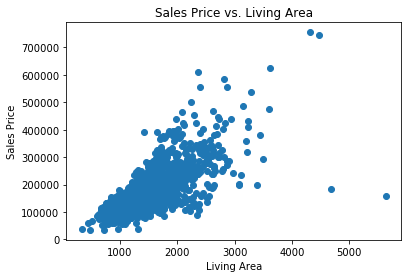

In [4]:
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.xlabel("Living Area")
plt.ylabel("Sales Price")
plt.title("Sales Price vs. Living Area")
plt.show()

There appear to be four points that are outliers.  All have living areas above 400 square feet.
#### Remove outliers in the data for all GrLivArea greater than 4000 then check the scatter plot again

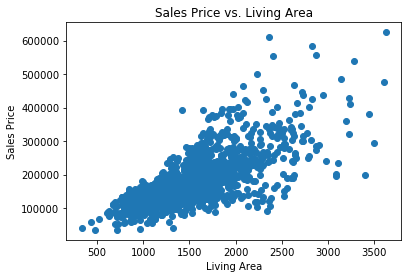

In [5]:
#Define living area outlier filter
living_area_filter = train['GrLivArea'] < 4000

# Apply the filter
train = train.loc[living_area_filter, :]

#TODO: Scatter plot
plt.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.xlabel("Living Area")
plt.ylabel("Sales Price")
plt.title("Sales Price vs. Living Area")
plt.show()

#### Impute missing data by the mean of each column.

I have reordered the steps for creating dummy variables and filling missing values.  With the original sequence we would be imputing fractional values for many of our categorical variables.  Given that they are categorical variables they should be clearly in one category or another. 

In addition to changing the sequence, I also elected to used the mode to fill `NA`'s in the categorical data.   

In [6]:
# Find the NAs
train.isnull().sum().sum()

6952

In [7]:
# Prepare to impute the mode for categorical variables in the training data.  
all_cols = train.columns

# Create a filter that filters the column names based on data type.
object_dtype = train.dtypes == 'object'

# Apply filter to list of colunm names to create lists of object & numeric cols
object_cols = all_cols[object_dtype]
numeric_cols = all_cols[~object_dtype]

# Find the Mode for each of the categorical variables
mode_na_fill = train.loc[:, object_cols].mode(axis = 0).iloc[0]

In [8]:
# Find Fill values for numeric column NA. 
mean_na_fill = train.loc[:, numeric_cols].mean()

In [9]:
# Replace Null values
train = train.fillna(mode_na_fill)
train = train.fillna(mean_na_fill)

In [10]:
# Check that all null values have been replaced
train.isnull().sum().sum()

0

#### Convert categorical variable into dummy variables using pandas get_dummies API

In [11]:
train.shape

(1456, 80)

In [12]:
train2 = pd.get_dummies(train, columns = object_cols)
train2.shape

(1456, 288)

Generate train test split 70/30

In [13]:
# Prepare data fro training and testing split
input_features = train2.drop(['SalePrice'], axis = 1)
response = train2['SalePrice']

In [14]:
# Create Training and testing split
x_train, x_test, y_train, y_test = train_test_split(input_features,
                                                    response,
                                                   test_size = .3,
                                                   train_size = .7,
                                                   random_state = 42)

## Linear Regression

In [15]:
#from numpy import sqrt

#Initalize Class & fit the model
linear_reg = LinearRegression()
linear_model = linear_reg.fit(x_train, y_train)

# Predict response on testing data
linear_y_pred = linear_model.predict(x_test)

#Compute the RMSE 
linear_rmse = np.sqrt(mean_squared_error(y_test, linear_y_pred))
print("RMSE - Linear Regression: {}".format(linear_rmse.round(2)))

RMSE - Linear Regression: 23808.26


## Lasso Regression

#### Fit lasso regression to training data with alpha 20. (Bonus: You could try CV to find the best alpha within a range)

In [16]:
# Define a Lasso model object
lasso = Lasso(max_iter = 5000)

# Set up grid search to find the best alpha
search_parameters = {'alpha' : [15, 20, 25, 30, 35, 40,
                                45, 50, 55, 60, 65, 70,
                                75, 80, 85, 90, 95, 100]}
grid_search = GridSearchCV(lasso,
                           param_grid = search_parameters,
                           cv = 10,
                           scoring = 'neg_mean_squared_error',
                           return_train_score = True)

grid_search_results = grid_search.fit(x_train, y_train)

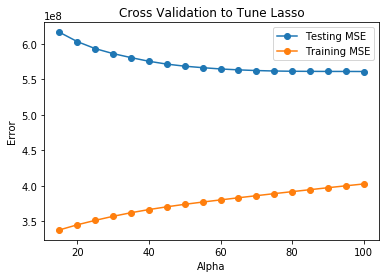

In [17]:
# Create data frame from cv_results
grid_results_df = pd.DataFrame(grid_search_results.cv_results_)

# Plot CV Results
plt.plot(grid_results_df['param_alpha'],
         (grid_results_df['mean_test_score'] * -1),
         label = 'Testing MSE',
         marker = 'o')
plt.plot(grid_results_df['param_alpha'],
         (grid_results_df['mean_train_score'] * -1),
         label = 'Training MSE',
         marker = 'o')
plt.ylabel("Error")
plt.xlabel('Alpha')
plt.title("Cross Validation to Tune Lasso")
plt.legend()

plt.show()

Based on cross validation I would select an alpha of 55.  Looking at the MSE for the testing data we see that the it decreases as alpha increases, but the decrease begins to level off around 55.

In [18]:
# Fit model with selected alpha
lasso_final = Lasso(alpha = 55)
lasso_model = lasso_final.fit(x_train, y_train)

# predict on testing data
lasso_y_pred = lasso_model.predict(x_test)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_y_pred))

print('Root Mean Squared Error: {}'.format(lasso_rmse.round(2)))

Root Mean Squared Error: 22183.47


#### How many columns has the model chosen?

In [19]:
# Save as an arrya
lcs = (lasso_model.coef_)
# Count coef not equal to zero
print("Number of Columns Selected {}".format(len([n for n in lcs if n != 0])))

Number of Columns Selected 148


## Ridge Regression

#### Perform ridge regression with alpha set to 0.1 and normalize to True. (Bonus: You could try CV to find the best alpha within a range). 

In [20]:
ridge = Ridge(alpha = 0.1, normalize = True)
ridge_model = ridge.fit(x_train, y_train)

#### What is your root mean squared error (RMSE)? Comment on your observation.

In [21]:
# Predicting on testing data
ridge_y_pred= ridge_model.predict(x_test)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_y_pred))

print('Ridge Regression Root Mean Squared Error {}'.format(ridge_rmse.round(2)))

Ridge Regression Root Mean Squared Error 22448.3


The ridge regression performs slight better than the original linear regression model. 

## Elastic Net Regression

#### Perform elastic net regression with different values of alpha (0.01, 0.1 and 20). Compute the RMSE as well. 


In [22]:
alphas = (0.01, 0.1, 20)

for a in alphas:
    elastic = ElasticNet(alpha = a)
    elastic_model = elastic.fit(x_train, y_train)
    elastic_y_pred = elastic_model.predict(x_test)
    elastic_rmse = np.sqrt(mean_squared_error(y_test, elastic_y_pred))
    
    print('Alpha:{}, RMSE:{}'.format(a, elastic_rmse.round(2)))

/Users/SeanWarlick/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Alpha:0.01, RMSE:22302.02
Alpha:0.1, RMSE:22521.29
Alpha:20, RMSE:30894.45


An alpha of 0.01 performs better than the ridge regression.  Lasso is model still performs the best based on RMSE. 